In [1]:
# Process and standardize data file to contrain 
# label_bin: numerical label for classification, 0 vs 1. 
# General strategy: Combine both train and test sets natively, then split later 

In [2]:
import pandas as pd, numpy as np 
import os, sys
import random
import torch

sys.path.append("../Code/utils/")
from text_processing import process_tweet_bert
from ekphrasis.classes.segmenter import Segmenter
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

In [3]:
from math import ceil
def round_halfup(x): 
    if x >= 0.5: 
        return ceil(x)
    return 0

In [4]:
def check_unique(f):
    return f.shape[0] ==  len(np.unique(f.id))

In [5]:
# segmenter using the word statistics from english Wikipedia
SEED=123
K_test = 2000

seg_eng = Segmenter(corpus="english") 
seg_tw = Segmenter(corpus="twitter") 

Reading english - 1grams ...
Reading english - 2grams ...


//Users/hn/Desktop/COVID_Racism/env/lib/python3.8/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...
Reading twitter - 2grams ...


In [6]:
std_columns = ['id','text_all','text_std',  'label_bin', 'label_orig', 'label_target']
save_dir = 'Meta_data/Raw/'
sep = ','

In [7]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [8]:
def fill_text_na(df:pd.DataFrame, cols: list = ['text_std'], fill_value=' '):
    """
        Fill text variables with space for tokenizer to work
    """
    dt = df.copy()
    dt[cols] =  df[cols].fillna(fill_value)
    return dt

### 1. DAVIDSON
- all data in 1 file --> Take 2000 randomly as separate test file
- Twitter
- From author: these will be designated label_orig category <br>
  0 - hate speech <br>
  1 - offensive  language <br>
  2 - neither

In [9]:
d = pd.read_csv("Davidson/labeled_data.txt", dtype={'class':int,  'tweet':str})
del d['Unnamed: 0']
d['id'] =  np.arange(d.shape[0]).astype(str)
d['id'] = 'davidson_' +  d.id 

In [10]:
d['label_bin'] = d['class'].apply(lambda x: 0 if x== 2 else 1)

(24783, 8)


<AxesSubplot:>

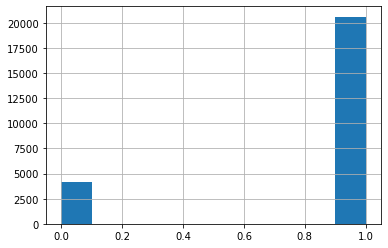

In [11]:
print(d.shape)
d.label_bin.hist()

In [12]:
d['text_std'] = d.tweet.apply(lambda x: process_tweet_bert(x, dict(), seg_tw, verbose=False))
d = fill_text_na(d)
d['text_all'] = d.tweet
d.head(1)

,count,hate_speech,offensive_language,neither,class,tweet,id,label_bin,text_std,text_all
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,davidson_0,0,!!! <user> as a woman you shouldn't complain a...,!!! RT @mayasolovely: As a woman you shouldn't...


In [13]:
set_seed(SEED)
d['label_orig'] = d['class']

In [14]:
assert check_unique(d)
d[[c for c in std_columns if c in d.columns]].to_csv(save_dir + "davidson.csv", index=None, sep=sep)

In [15]:
del d

## 2. TRAC
- train/dev/test separate, facebook <br>
- Orig Categories: 3 levels, NO TARGET <br>
BINARY CONVERSION: 
- covert aggression to 1 <br>
- aggression overt to 1 <br>
- NOT aggression overt or covert aggression to 0 

In [16]:
trac_cols = ['fbid', 'text', 'agg_lvl']
t_train = pd.read_csv("Trac/english/agr_en_train.csv", names=trac_cols)
t_dev = pd.read_csv("Trac/english/agr_en_dev.csv", names=trac_cols)

In [17]:
t_test = pd.read_csv("Trac/trac-gold-set/agr_en_fb_gold.csv", names=trac_cols) 

In [18]:
trac = pd.concat([t_train, t_dev, t_test])
trac['id'] = trac.fbid

In [19]:
trac['text_std'] = trac.text.apply(lambda x: process_tweet_bert(x, dict(), seg_tw, verbose=False))
trac['text_all'] = trac.text

In [20]:
print(trac.agg_lvl.unique())
trac_dict = {'NAG':0, 'CAG':1, 'OAG':2}
trac['label_orig'] = trac.agg_lvl.apply(lambda x: trac_dict[x])

['OAG' 'NAG' 'CAG']


In [21]:
trac['label_bin'] = trac.agg_lvl.apply(lambda x: 0 if x=='NAG' else 1) 
# trac = fill_text_na(trac)

In [22]:
print(trac.shape)
trac.head(2)

(15916, 8)


,fbid,text,agg_lvl,id,text_std,text_all,label_orig,label_bin
0,facebook_corpus_msr_1723796,Well said sonu..you have courage to stand agai...,OAG,facebook_corpus_msr_1723796,well said sonu..you have courage to stand agai...,Well said sonu..you have courage to stand agai...,2,1
1,facebook_corpus_msr_466073,"Most of Private Banks ATM's Like HDFC, ICICI e...",NAG,facebook_corpus_msr_466073,"most of private banks atm's like hdfc, icici e...","Most of Private Banks ATM's Like HDFC, ICICI e...",0,0


<AxesSubplot:>

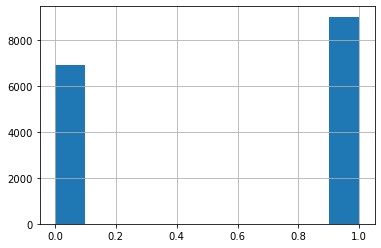

In [23]:
trac.label_bin.hist()

In [24]:
assert check_unique(trac)
trac[[c for c in std_columns if c in trac.columns]].to_csv(save_dir + "trac.csv", index=None, sep=sep) 

In [25]:
del trac, t_train, t_dev, t_test, trac_cols, trac_dict

### 3. JIGSAW - KAGGLE
- MULTI, non-exclusive label --> How to distill to just 1 label 
-Original categories
-- Toxic, servere_toxic, obscene, identity_hate, threat, insult (similar to Toxic API)


In [26]:
## Founta paper only used the training set, which is plenty enough
j_train = pd.read_csv("Jigsaw/train.csv")
# j_test_lbl = pd.read_csv("Jigsaw/test_labels.csv")
# j_test = pd.read_csv("Jigsaw/test.csv")

In [27]:
label_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
j_train['label_bin'] = j_train[label_cols].apply(lambda x: 0 if sum(x) == 0 else 1, axis=1)

In [28]:
j_labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
j_train['label_orig'] = j_train[j_labels].apply(lambda x: [y for y in x], axis=1)

In [29]:
j_train['text_std'] = j_train.comment_text.apply(lambda x: process_tweet_bert(x, dict(), seg_tw, verbose=False))
j_train = fill_text_na(j_train) 
j_train['text_all'] = j_train.comment_text

In [30]:
print(j_train.shape)
j_train.head(2)

(159571, 12)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_bin,label_orig,text_std,text_all
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]",explanation why the edits made under my userna...,Explanation\nWhy the edits made under my usern...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]",d'<url> he matches this background colour i'm ...,D'aww! He matches this background colour I'm s...


<AxesSubplot:>

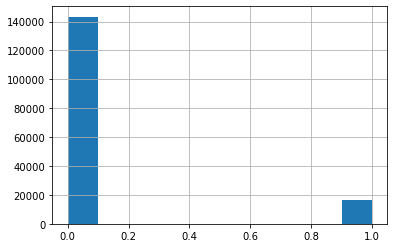

In [31]:
j_train.label_bin.hist()

In [32]:
assert check_unique(j_train)
j_train[[c for c in std_columns if c in j_train.columns]].to_csv(save_dir + "jigsaw.csv", index=None,sep=sep)

In [33]:
del j_train

## 4. FOUNTA 
- Twitter
- Original categories 4 categories: 
-- spam, abusive, normal, hateful 

In [34]:
founta = pd.read_csv('Founta/hatespeech_text_label_vote_RESTRICTED_100K.csv', sep="\t", 
                  names = ['text', 'label', 'num_ant'], dtype=str)

In [35]:
founta['id'] = np.arange(founta.shape[0]).astype(str)
founta['id'] = 'founta_' + founta.id

In [36]:
founta_dict = {'spam':0, 'abusive':2, 'normal':1, 'hateful':3}
founta['label_orig'] = founta.label.apply(lambda x: founta_dict[x])

In [37]:
founta['label_bin'] = founta.label.apply(lambda x: 0 if x in ('spam','normal') else 1)

In [38]:
founta['text_std'] = founta.text.apply(lambda x: process_tweet_bert(x, dict(), seg_tw, verbose=False))
founta = fill_text_na(founta)
founta['text_all'] = founta.text

,text,label,num_ant,id,label_orig,label_bin,text_std,text_all
0,Beats by Dr. Dre urBeats Wired In-Ear Headphon...,spam,4,founta_0,0,0,beats by dr. dre urbeats wired in-ear headphon...,Beats by Dr. Dre urBeats Wired In-Ear Headphon...
1,RT @Papapishu: Man it would fucking rule if we...,abusive,4,founta_1,2,1,<user> man it would fucking rule if we had a p...,RT @Papapishu: Man it would fucking rule if we...
2,It is time to draw close to Him &#128591;&#127...,normal,4,founta_2,1,0,it is time to draw close to him & 128591;& 127...,It is time to draw close to Him &#128591;&#127...


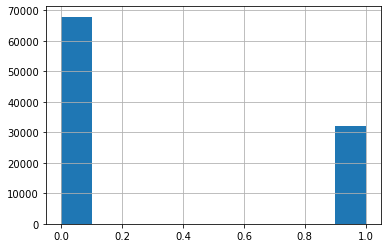

In [39]:
founta.label_bin.hist()
founta.head(3)

In [40]:
assert check_unique(founta)
founta[[c for c in std_columns if c in founta.columns]].to_csv(save_dir + "founta.csv", index=None, sep=sep)

In [41]:
del founta 

## 5.  HATEVAL
- Twitter
- Original categories: multilevel, similar to OLID 
-- HS - a binary value indicating if HS is occurring against one of the given targets (women
or immigrants): 1 if occurs, 0 if not. --> equivalent to label_bin
-- Target Range - if HS occurs (i.e. the value
for the feature HS is 1), a binary value indicating if the target is a generic group of people (0) or a specific individual (1).
-- Aggressiveness - if HS occurs (i.e. the value
for the feature HS is 1), a binary value indicating if the tweeter is aggressive (1) or
not (0).

In [42]:
h_train = pd.read_csv("Hateval/hateval2019_en_train.csv")
h_dev = pd.read_csv("Hateval/hateval2019_en_dev.csv")
# h_test = pd.read_csv("Hateval/hateval2019_en_test.csv")
hateval = pd.concat([h_train, h_dev])

In [43]:
hateval['label_bin'] = hateval.HS
hateval['label_target'] = hateval.TR

In [44]:
hateval['text_std'] =  hateval.text.apply(lambda x: process_tweet_bert(x, dict(), seg_tw, verbose=False))
hateval = fill_text_na(hateval)
hateval['text_all'] = hateval.text

In [45]:
hateval['label_orig'] = hateval.HS
hateval.label_orig = hateval.label_orig + hateval.AG

In [46]:
hateval.head(2)

,id,text,HS,TR,AG,label_bin,label_target,text_std,text_all,label_orig
0,201,"Hurray, saving us $$$ in so many ways @potus @...",1,0,0,1,0,"hurray, saving us $$$ in so many ways <user> l...","Hurray, saving us $$$ in so many ways @potus @...",1
1,202,Why would young fighting age men be the vast m...,1,0,0,1,0,why would young fighting age men be the vast m...,Why would young fighting age men be the vast m...,1


(10000, 10)


<AxesSubplot:>

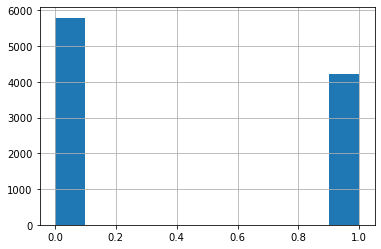

In [47]:
print(hateval.shape)
hateval.label_bin.hist()

In [48]:
# hateval[[c for c in std_columns if c in hateval.columns]]

In [49]:
assert check_unique(hateval)
hateval[[c for c in std_columns if c in hateval.columns]].to_csv(save_dir + "hateval.csv", index=None, sep=sep)

In [50]:
del h_train, h_dev, hateval

## 6. OLID/ OFFENSEVAL
- Multi level-hierachical annotation
- Test set independent, but small
- Subtask a corresponds to binary label 
- LEVEL 1: used for binary
- LEVEL 2 : used for label_orig conversion: 0: (NOT,_), 1: (OFF, UNT), 2:(OFF, TIN)
- LEVEL 3: target

In [51]:
label_dict = {'NOT':0, 'OFF':1, 'NA': 0,'TIN':1, 'UNT':2, 'GRP':1, 'IND':2, 'OTH':3}
olid_train = pd.read_csv('Olid/olid-training-v1.0.tsv', delimiter='\t')

In [52]:
olid_train = olid_train.fillna('NA')
olid_train[['label_a', 'label_b', 'label_c']] = np.NAN
temp =  [olid_train[c].apply(lambda x: label_dict[x]) for c in ['subtask_a','subtask_b','subtask_c']]
olid_train.label_a, olid_train.label_b, olid_train.label_c = temp

In [53]:
pd.crosstab(olid_train.subtask_a, olid_train.subtask_c)

subtask_c,GRP,IND,NA,OTH
subtask_a,,,,
NOT,0,0,8840,0
OFF,1074,2407,524,395


In [54]:
olid_train['label_bin'] = olid_train.label_a 
olid_train['label_orig'] = olid_train.label_b

In [55]:
olid_train['label_target'] = olid_train.label_c
pd.crosstab(olid_train.label_target, olid_train.subtask_c)

subtask_c,GRP,IND,NA,OTH
label_target,,,,
0,0,0,9364,0
1,1074,0,0,0
2,0,2407,0,0
3,0,0,0,395


In [56]:
olid_train['text_std'] = olid_train.tweet.apply(lambda x: process_tweet_bert(x, dict(), seg_tw, verbose=False))
olid_train = fill_text_na(olid_train)
olid_train['text_all'] = olid_train.tweet

In [57]:
assert check_unique(olid_train)
olid_train[[c for c in std_columns if c in olid_train.columns]].to_csv(save_dir + "olid.csv", index=None, sep=sep)

In [58]:
del olid_train, label_dict

## 7. STORMFRONT - de GilBert
Orig category: binary hate vs note hate

In [59]:
newfile = open('Stormfront/stormfront_all.txt', 'w+')
for file in os.listdir('Stormfront/all_files'):
    if 'txt' in file:
        fid = file.split('.')[0]
        l = open("Stormfront/all_files/"+file).readline()
        line = fid+'\t'+l+'\n'
        newfile.write(line)
newfile.close()
    

In [60]:
sf = pd.read_csv("Stormfront/stormfront_all.txt", names=['id','text'], dtype=str, delimiter='\t')

In [61]:
sf_annot = pd.read_csv("Stormfront/annotations_metadata.csv")

In [62]:
assert sf_annot.file_id.nunique() == sf_annot.shape[0]

In [63]:
sf_orig_shape = sf.shape
sf = pd.merge(sf, left_on='id', right=sf_annot, right_on='file_id', how='left')
assert sf_orig_shape[0] == sf.shape[0]

In [64]:
sf.label.unique()

array(['noHate', 'idk/skip', 'relation', 'hate', nan], dtype=object)

<AxesSubplot:>

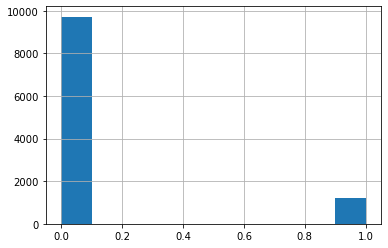

In [65]:
sf['label_bin'] = sf.label.apply(lambda x: 1 if x == 'hate' else 0)
sf.label_bin.hist()

Note: way too few positive samples. Considered discarding....

In [66]:
del newfile, sf, sf_annot

## 8. METOO
- Twitter: only tweetids given, many tweets already deleted
- First level: directed vs generalized hate 
- Relevance, Directed Hate, Generalized Hate, Sarcasm, Allegation, Justification, ,Refutation, Support,Oppose

In [67]:
metoo_annot = pd.read_csv("MeToo/MeTOOMA.csv")

In [68]:
metoo_tweetids = metoo_annot[['TweetId']]
metoo_tweetids.columns = ['tweetid']
metoo_tweetids.to_csv("MeToo/metoo_tweetids.csv", index=None, sep=sep)

In [69]:
metoo_tweets = pd.read_csv('MeToo/MeToo_tweets.csv')[['id','text']]

In [70]:
metoo = pd.merge(left = metoo_annot, left_on='TweetId', right=metoo_tweets, right_on='id')

In [71]:
metoo['label_bin'] = metoo[['Directed_Hate',	'Generalized_Hate']].apply(lambda x: 1 if sum(x) > 0 else 0, axis=1)

<AxesSubplot:>

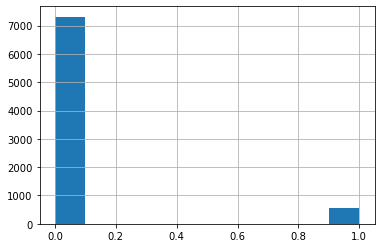

In [72]:
metoo.label_bin.hist()

In [73]:
del metoo, metoo_annot, metoo_tweetids, metoo_tweets

## 9. WASEEM
- Twitter: racism and sexism
- Originally 16K tweets, now only 10k left as of Oct 2022

** NOTE: WASEEM HAS SOME WEIRD ENCODING: pre-process text before saving

In [74]:
waseem_all = pd.read_csv("Waseem/NAACL_SRW_2016.csv", names=['tweetid','label'])

In [75]:
# waseem_all[['tweetid']].to_csv("Waseem/waseem_tweetids.csv", index=None, header=None)

In [76]:
waseem_labels = waseem_all.groupby('tweetid').label.max().reset_index()

In [77]:
waseem_dict = {'none':0, 'sexism':1, 'racism':2}
waseem_labels['label_bin'] = waseem_labels.label.apply(lambda x : 0 if x == 'none' else 1)
waseem_labels['label_orig'] = waseem_labels.label.apply(lambda x: waseem_dict[x])

In [78]:
# waseem = waseem_all.groupby('tweetid').label_bin.max().reset_index()

In [79]:
waseem_tweets = pd.read_csv("Waseem/waseem_tweets.csv")[['id', 'text']]
waseem_tweets.columns = ['tweetid', 'text']

In [80]:
waseem = pd.merge(left=waseem_labels, left_on='tweetid', right=waseem_tweets, right_on='tweetid')

In [81]:
waseem = waseem.drop_duplicates().reset_index()
waseem['id'] = 'waseem_' + waseem.tweetid.astype(str)

<AxesSubplot:>

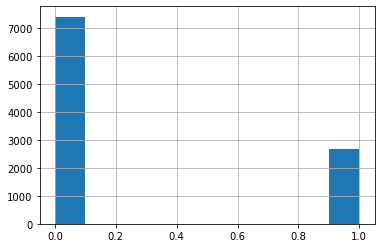

In [82]:
waseem.label_bin.hist()

In [83]:
waseem['text_std'] = waseem.text.apply(lambda x: process_tweet_bert(x, dict(), seg_tw, verbose=False))
waseem['text_all']  = waseem.text.apply(lambda x: x.encode("utf-8"))

In [84]:
#drop all rows without a label_bin 
waseem = waseem[waseem.label_bin == waseem.label_bin]
assert check_unique(waseem)
waseem[[c for c in std_columns if c in waseem.columns]].to_csv(save_dir + "waseem.csv", index=None, sep=sep)

## 10. GOLBECK 
- Twitter
- Original class: Harrasment or Not 

In [85]:
d = pd.read_csv("Goldbeck/onlineHarassmentDataset.tdf", sep='\t', encoding='latin-1')
d = d[['ID','Code','Tweet']]  

In [86]:
goldbeck_dict = {'H':1, 'N':0}
d['id'] = 'goldbeck_' + d.ID.astype(str)

<AxesSubplot:>

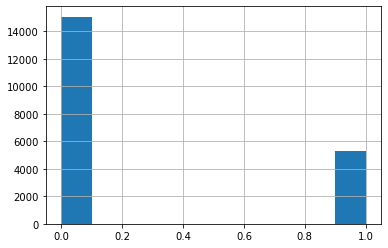

In [87]:
d['label_bin'] = d.Code.apply(lambda x: goldbeck_dict[x])
d['label_orig'] = d.label_bin
d['text_all']  = d.Tweet.apply(lambda x: x.encode("utf-8").decode('utf-8'))
d.label_bin.hist()

In [88]:
d['text_std'] = d.Tweet.apply(lambda x: process_tweet_bert(x, dict(), seg_tw, verbose=False))

In [89]:
assert check_unique(d)
d[[c for c in std_columns if c in d.columns]].to_csv(save_dir + 'goldbeck.csv', sep=sep)
del d

## 11.  Gab_Kennedy
- GAB
- “assaults on human dignity” (HD)
- “calls for violence” (CV)
- "vulgarity/ offensive"  (VO)
- Also multiple levels of targets: RAE, NAT, GEN, REL, SXO, IDL, POL, MPH, EX, IM

In [90]:
# using train only dataset
k_train  = pd.read_csv("Gab_kennedy/ghc_train.tsv", sep='\t')
k_test  = pd.read_csv("Gab_kennedy/ghc_test.tsv", sep='\t')
k = pd.concat([k_train,k_test])
k_targets = ['REL', 'RAE','SXO', 'GEN', 'IDL', 'NAT', 'POL', 'MPH', 'EX', 'IM']
print(k.shape)

(27546, 4)


In [91]:
# Aggreegate by majority for target label
ka = pd.read_csv("Gab_kennedy/GabHateCorpus_annotations.tsv", sep="\t")
ka.fillna(0, inplace=True) 

In [92]:
# target is binary ?
assert all([t == set((0.,1)) for t in [set(ka[c].unique().tolist()) for c in ['REL', 'RAE'] ]])

In [93]:
# targert is rounded up if at least half of annotators agree
k_temp = ka.groupby('ID')[k_targets].sum() / ka.groupby('ID')[k_targets].count()
k_temp = k_temp.applymap(round_halfup)

In [94]:
k = pd.merge(left=k, left_index=True, right=k_temp, right_index=True, how='inner')
k.columns = [c.lower() for c in k.columns]

In [95]:
k = k.drop_duplicates().reset_index()

k['id'] =  'gab_kennedy_' + k.index.astype(str)
k['label_orig'] = k[['hd','cv','vo']].apply(lambda x: [y for y in  x.values], axis=1)
k['label_bin'] = k[['hd','cv', 'vo']].apply(lambda x: 1 if np.max(x) == 1 else 0, axis=1)

In [96]:
k_targets =[c.lower() for c in k_targets] 
k['label_target'] = k[k_targets].apply(lambda x: [y for y in  x.values], axis=1)

In [97]:
k['text_std'] = k.text.apply(lambda x: process_tweet_bert(x, dict(), seg_tw, verbose=False))
k['text_all'] = k.text_std
k.head(2)

,index,text,hd,cv,vo,rel,rae,sxo,gen,idl,...,pol,mph,ex,im,id,label_orig,label_bin,label_target,text_std,text_all
0,0,He most likely converted to islam due to his n...,0,0,0,0,0,0,0,0,...,0,0,0,0,gab_kennedy_0,"[0, 0, 0]",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",he most likely converted to islam due to his n...,he most likely converted to islam due to his n...
1,0,https://www.youtube.com/watch?v=kACWpKAKtak A ...,0,0,0,0,0,0,0,0,...,0,0,0,0,gab_kennedy_1,"[0, 0, 0]",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",<url> talk on natural law.,<url> talk on natural law.


In [98]:
assert check_unique(k)
k[[c for c in std_columns if c in k.columns]].to_csv(save_dir + 'gab_kennedy.csv', sep=sep)
del k

## 12. SAB 
- test set provided
- contains implicit hate speech + all annotatoions --> needs distillation
- Use target_category as key for label_target
- Use offensiveYN for label_bin --> NOT MULTILABLE CLASSIFICATION

In [99]:
sb_train = pd.read_csv("social_bias/SBFv2.trn.csv")
sb_test = pd.read_csv("social_bias/SBFv2.tst.csv")
sb_train.head(1)

,whoTarget,intentYN,sexYN,sexReason,offensiveYN,annotatorGender,annotatorMinority,sexPhrase,speakerMinorityYN,WorkerId,HITId,annotatorPolitics,annotatorRace,annotatorAge,post,targetMinority,targetCategory,targetStereotype
0,0.0,0.66,0.0,NaN,1.0,woman,NaN,NaN,NaN,-8935932304856669427,363A7XIFV4G2799C5V96YERJA9AVAM,liberal,white,45.0,RT @_LexC__: I'm convinced that some of y'all ...,NaN,NaN,NaN


In [100]:
# train test mutual exclusive?
assert len(set(sb_train.HITId).intersection(set(sb_test.HITId))) == 0
sb_all = pd.concat([sb_train, sb_test])

In [101]:
sb = sb_all[['HITId', 'post']].drop_duplicates()
assert sb.shape[0] == sb.HITId.nunique()
sb.set_index('HITId', inplace=True)

In [102]:
# too many catogories, cannot be used for testing 
print("number of categories in target Minority:", len((sb_train.targetMinority.unique())))
sb_all.targetCategory.unique()

number of categories in target Minority: 1180


array([nan, 'race', 'gender', 'social', 'body', 'culture', 'disabled',
       'victim'], dtype=object)

In [103]:
# proces offensiveYN 
offense = pd.DataFrame(sb_all.groupby('HITId')['offensiveYN'].mean())

In [104]:
# process target
sb_target = pd.pivot_table(sb_all, index='HITId', columns='targetCategory', values='WorkerId', aggfunc='count')
sb_targetdict = {i: c for i, c in enumerate(sb_target.columns)}

In [105]:
target = pd.DataFrame(sb_target.apply(lambda x: np.argmax(x), axis=1))
target.columns=['targetCategory']

In [106]:
sb = pd.concat([sb, offense, target], axis=1)

In [107]:
## standardize variables
sb['label_bin'] = sb.offensiveYN.apply(lambda x:1 if x>= 0.5 else 0)
sb['label_orig'] = sb.label_bin
# no-categories are set at 0
sb['label_target'] = sb.targetCategory.apply(lambda x : int(x) + 1 if x == x else 0 )

In [108]:
sb['text_std'] = sb.post.apply(lambda x: process_tweet_bert(x, dict(), seg_tw, verbose=False))

In [109]:
sb.reset_index(inplace=True)
sb['id'] = 'sab_' + sb.HITId
sb['text_all'] = sb.post

In [110]:
# set_seed(SEED)
# sab_train = sb.loc[sb.HITId.isin(sb_train.HITId),std_columns + ['label_orig', 'label_target'] ]
# sab_test = sb.loc[sb.HITId.isin(sb_test.HITId),std_columns + ['label_orig', 'label_target'] ]
# sab_test = sab_test.sample(n=2000, random_state=SEED)

In [111]:
assert check_unique(sb)
sb[[c for c in std_columns if c in sb.columns]].to_csv(save_dir + 'sab.csv', sep=sep)
del sb